In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from time import time
from PINN.European import EuropeanPINN
from PINN.utilities import V_BS, V_BS_CN

import warnings
warnings.filterwarnings("ignore")

BS PDE
$$
\frac{\partial V}{\partial \tau}-\frac{\sigma^2 S^2}{2} \frac{\partial^2 V}{\partial S^2}-r S \frac{\partial V}{\partial S}+r V=0.
$$

For European put option, we have initial and boundary conditions
$$
V(S, 0) = (K - S)^+, V(0, \tau) = Ke^{-r\tau}, V(\infty, \tau) = 0.
$$

For European options, we have analytic solutions
$$
V(S, \tau)=K e^{-r \tau}\left(1-N\left(d_2\right)\right)+\left(N\left(d_1\right)-1\right) S,
$$
where
$$
d_1=\frac{\log (S / K)+\left(r+0.5 \sigma^2\right) \tau}{\sigma \sqrt{\tau}}, d_2=\frac{\log (S / K)+\left(r-0.5 \sigma^2\right) \tau}{\sigma \sqrt{\tau}}.
$$



In [6]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
print('Device:', device)
# load data
ib = torch.load('data/european_put_ib.pt')
pde = torch.load('data/european_put_pde.pt')
S_ib, tau_ib, V_ib = ib['S'], ib['tau'], ib['V']
S_pde, tau_pde = pde['S'], pde['tau']

# parameters
K = 4
sigma = 0.3
r = 0.03
T = 1
S_inf = 3 * K
N_pde = 2500

TRAIN = False

Device: cpu


Number of parameters: 501


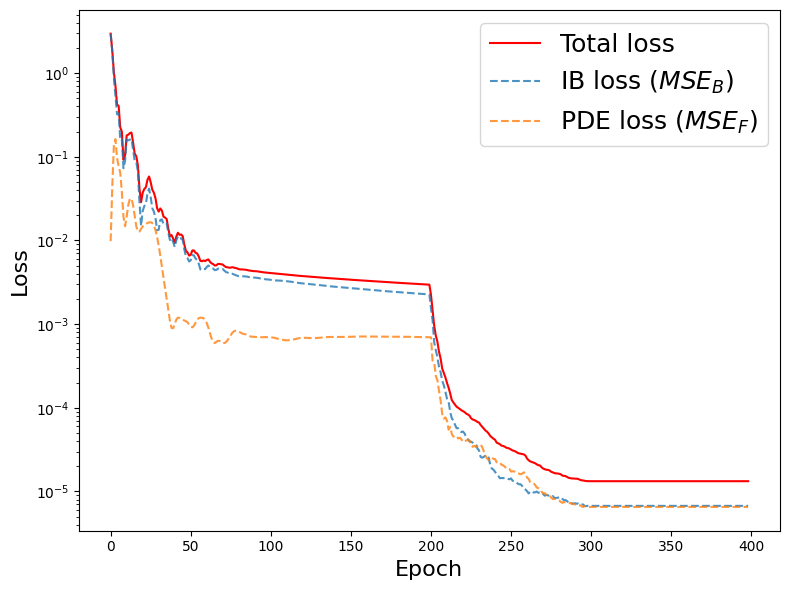

Final loss: 1.3270479485072428e-05


In [7]:
model_name = 'european_put_2mlp20'
# model_name = 'european_put_2mlp20_v2'
if TRAIN:
    nn = torch.nn.Sequential(
            torch.nn.Linear(2, 20),
            torch.nn.Tanh(),
            torch.nn.Linear(20, 20),
            torch.nn.Tanh(),
            torch.nn.Linear(20, 1)
    )
    model = EuropeanPINN(nn, K, T, r, sigma, S_inf, device=device).to(device)
    loss_weights = (1., 1., 1.)

    training_time = time()
    # First train with Adam for 100 epochs
    model.fit(S_ib, tau_ib, V_ib,
              S_pde, tau_pde,
              N_pde=N_pde, resample=0, loss_weights=loss_weights,
              epochs=200, optimizer='adam', lr=0.005)
    # Then train with L-BFGS for 200 epochs
    model.fit(S_ib, tau_ib, V_ib,
              S_pde, tau_pde,
              N_pde=N_pde, resample=0, loss_weights=loss_weights,
              epochs=300, optimizer='lbfgs', line_search_fn='strong_wolfe')
    training_time = time() - training_time
    print('Training time:', training_time)
    # save model
    torch.save(model, f'models/{model_name}.pt')

model = torch.load(f'models/{model_name}.pt', map_location=device)
print('Number of parameters:', sum(p.numel() for p in model.parameters()))
model.plot_loss(data=False, save=True, title='', figsize=(8, 6), fontsize=16, file_name=f'data/images/loss_{model_name}.pdf')
print('Final loss:', model.loss_history['total'][-1])

MSE: 7.01817271570817e-07
RMSE: 0.0008377453500741242
-0.01492720039501183 0.02578347588038099


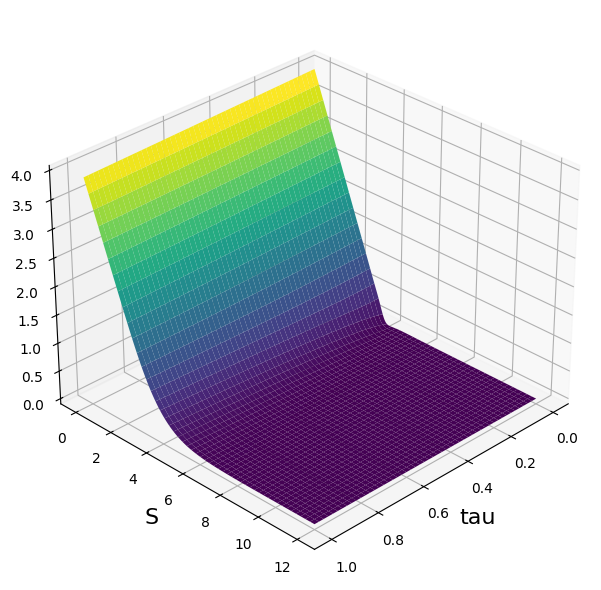

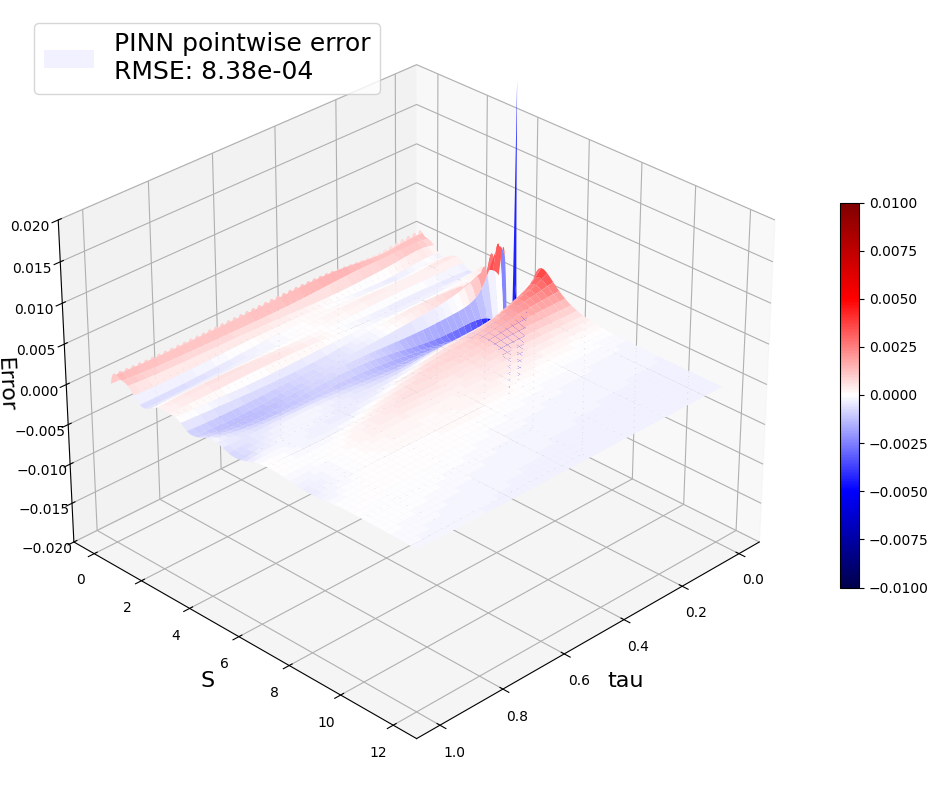

In [8]:
# model_name = 'european_put_2mlp20'
# model = torch.load(f'models/{model_name}.pt', map_location=device)

S_inf_eval = 3 * K - 1e-8
S_eval = torch.linspace(0, S_inf_eval, 1000)
tau_eval = torch.linspace(0, T, 1000)
S_eval, tau_eval = torch.meshgrid(S_eval, tau_eval)  # torch meshgrid uses different indexing
V_pred = model(S_eval.reshape(-1, 1), tau_eval.reshape(-1, 1)).detach().numpy().reshape(1000, 1000).T

# compute error metrics
# Using np.meshgrid, torch.meshgrid uses different indexing
S_eval = np.linspace(0, S_inf_eval, 1000)
tau_eval = np.linspace(0, T, 1000)
S_eval, tau_eval = np.meshgrid(S_eval, tau_eval)
V_true = V_BS(S_eval, tau_eval, K, r, sigma, 'put')
# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection='3d')
# surf = ax.plot_surface(S_eval, tau_eval, V_true, cmap='viridis')
V_err = V_pred - V_true
MSE = np.mean(V_err**2)
RMSE = np.sqrt(MSE)
print('MSE:', MSE)
print('RMSE:', RMSE)
print(V_err.min(), V_err.max())

# 3d plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(tau_eval, S_eval, V_pred, cmap='viridis')
ax.set_xlabel('tau', fontsize=16)
ax.set_ylabel('S', fontsize=16)
# ax.set_zlabel('V', fontsize=14)
ax.view_init(elev=30, azim=45)
plt.tight_layout()
plt.savefig('./data/images/sol_european_3d.pdf', bbox_inches='tight')
plt.show()

# plot error surface
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(tau_eval, S_eval, V_err, label=f'PINN pointwise error\nRMSE: {RMSE:.2e}', cmap='seismic', vmin=-0.01, vmax=0.01)
cbar = fig.colorbar(surf, location='right', shrink=0.5)
ax.set_zlim(-0.02, 0.02)
ax.set_xlabel('tau', fontsize=16)
ax.set_ylabel('S', fontsize=16)
ax.set_zlabel('Error', fontsize=16)
plt.legend(fontsize=18)
ax.view_init(elev=30, azim=45)
plt.tight_layout()
plt.savefig('./data/images/sol_european_3d_err.pdf', bbox_inches='tight')
plt.show()

MSE: 8.53179339070192e-08
RMSE: 0.00029209233798067896
-0.0010429293070805465 0.026666664444444287


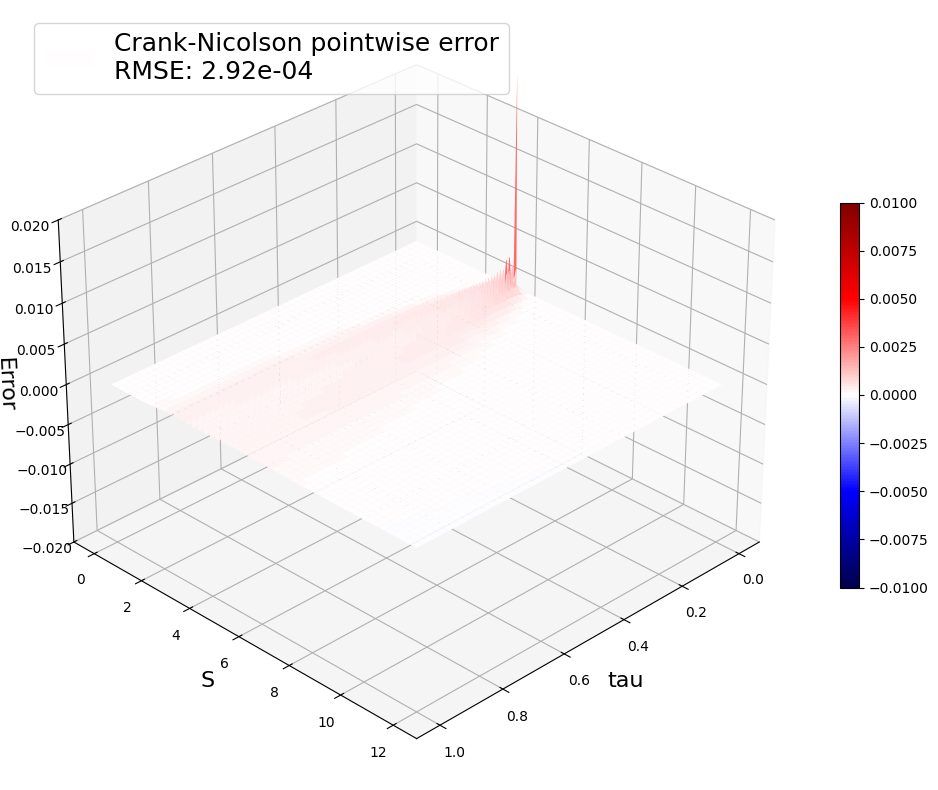

In [8]:
from scipy.interpolate import RegularGridInterpolator

# Crank-Nicolson solution
V_CN, S_CN, t_CN = V_BS_CN(100, 100, T, K, sigma, r, S_inf=K*3, type='put')
V_CN = V_CN.T

# interpolate CN solution on eval grid
interpolator = RegularGridInterpolator((S_CN, t_CN), V_CN, method='linear', bounds_error=False, fill_value=np.nan)
S_eval = np.linspace(0, S_inf_eval, 1000)
tau_eval = np.linspace(0, T, 1000)
S_eval, tau_eval = np.meshgrid(S_eval, tau_eval)
V_pred_CN = interpolator((S_eval, tau_eval))

# compute error metrics
V_true = V_BS(S_eval, tau_eval, K, r, sigma, 'put')
V_err_CN = V_pred_CN - V_true
MSE_CN = np.mean(V_err_CN**2)
RMSE_CN = np.sqrt(MSE_CN)
print('MSE:', MSE_CN)
print('RMSE:', RMSE_CN)
print(V_err_CN.min(), V_err_CN.max())


# # 3d plot CN solution
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(S_eval, tau_eval, V_pred_CN, cmap='viridis')
# ax.set_xlabel('S', fontsize=14)
# ax.set_ylabel('tau', fontsize=14)
# ax.set_zlabel('V', fontsize=14)
# ax.set_title('Crank-Nicolson Solution', fontsize=16)
# # plt.savefig('./data/images/sol_european_cn.pdf')
# plt.show()


# plot error surface
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(tau_eval, S_eval, V_err_CN, label=f'Crank-Nicolson pointwise error\nRMSE: {RMSE_CN:.2e}', cmap='seismic', vmin=-0.01, vmax=0.01)
cbar = fig.colorbar(surf, location='right', shrink=0.5)
ax.set_xlabel('tau', fontsize=16)
ax.set_ylabel('S', fontsize=16)
ax.set_zlabel('Error', fontsize=16)
ax.set_zlim(-0.02, 0.02)
plt.legend(fontsize=18)
ax.view_init(elev=30, azim=45)
plt.tight_layout()
plt.savefig('./data/images/sol_european_cn_err.pdf', bbox_inches='tight')
plt.show()